In [165]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from pymongo import MongoClient
from smartenergy.database.preprocessing import preprocess, group_data_hourly, add_date_features
from smartenergy.database.mongo_queries import load_all_stations_first_n, store_hourly_predictions, drop_predictions, load_predictions

from IPython.core.display import display, HTML
from jupyterthemes import jtplot
jtplot.style('onedork')

np.warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
display(HTML("<style>.container { width: 1480px !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
%%time
client = MongoClient(host='127.0.0.1', port=27017)
db = client['energy']

data = load_all_stations_first_n(db.measurements, int(1e4))
data = preprocess(data)
currents = ['fILoadDirect_avg', 'fILoad_avg', 'fIPV_avg', 'fIExcess_avg', 'fIToGrid_avg', 'fIToBat_avg']
stations = list(data.index.get_level_values(0).unique())

CPU times: user 15.5 s, sys: 1.92 s, total: 17.5 s
Wall time: 30.7 s


In [113]:
print(data.shape)
data.head()

(170000, 19)


fILoadDirect_avg  fILoad_avg  fIPV_avg  \
solbox_id datetime                                                      
190       2018-01-28 11:25:14            722.80     1519.43     78.26   
          2018-02-02 12:24:35             94.10      932.39    450.34   
          2018-02-02 16:35:50            101.42      941.48    136.18   
          2018-02-02 16:39:53             94.29      940.16    135.12   
          2018-02-02 16:41:50             94.27      937.58    132.61   

                               fIToGrid_avg  fIExcess_avg  fIToBat_avg  year  \
solbox_id datetime                                                             
190       2018-01-28 11:25:14          0.00          0.57         0.00  2018   
          2018-02-02 12:24:35        -12.56          0.07       281.39  2018   
          2018-02-02 16:35:50        -38.31          1.11       -16.11  2018   
          2018-02-02 16:39:53        -10.66          0.07       -43.51  2018   
          2018-02-02 16:41:50        -11.33          0.07       -42.75  2018   

                               month  week  weekday  day  hour  u8UserMode  \
solbox_id datetime                                                           
190       2018-01-28 11:25:14      1     4        6   28    11           1   
          2018-02-02 12:24:35      2     5        4    2    12           0   
          2018-02-02 16:35:50      2     5        4    2    16           2   
          2018-02-02 16:39:53      2     5        4    2    16           2   
          2018-02-02 16:41:50      2     5        4    2    16           2   

                               u8StateOfBattery  u32TotalBought  u32TotalSold  \
solbox_id datetime                                                              
190       2018-01-28 11:25:14                 2               0            54   
          2018-02-02 12:24:35                 3               0            43   
          2018-02-02 16:35:50                 3               0            43   
          2018-02-02 16:39:53                 3               0            43   
          2018-02-02 16:41:50                 3               0            43   

                               fBuyPrice  fSellPrice  fTemperature_avg  
solbox_id datetime                                                      
190       2018-01-28 11:25:14       1.92        1.20             23.75  
          2018-02-02 12:24:35       1.92        1.20             22.28  
          2018-02-02 16:35:50       1.92        1.20             24.26  
          2018-02-02 16:39:53       1.92        1.20             24.35  
          2018-02-02 16:41:50       1.92        1.20             24.34

In [114]:
data_hourly = group_data_hourly(data)
print(data_hourly.shape)
data_hourly.head()

(6253, 19)


year  month  day  hour  fILoadDirect_avg  \
solbox_id datetime                                                        
190       2018-01-28 11:00:00  2018      1   28    11            722.80   
          2018-02-02 12:00:00  2018      2    2    12             94.10   
          2018-02-02 16:00:00  2018      2    2    16             94.95   
          2018-02-02 17:00:00  2018      2    2    17            303.96   
          2018-02-02 18:00:00  2018      2    2    18            542.90   

                               fILoad_avg  fIPV_avg  fIToGrid_avg  \
solbox_id datetime                                                  
190       2018-01-28 11:00:00     1519.43     78.26          0.00   
          2018-02-02 12:00:00      932.39    450.34        -12.56   
          2018-02-02 16:00:00      937.30    126.65        -14.15   
          2018-02-02 17:00:00     1153.12     95.58        -37.19   
          2018-02-02 18:00:00     1401.60     91.07        -85.51   

                               fIExcess_avg  fIToBat_avg  week  weekday  \
solbox_id datetime                                                        
190       2018-01-28 11:00:00          0.57         0.00  4.00     6.00   
          2018-02-02 12:00:00          0.07       281.39  5.00     4.00   
          2018-02-02 16:00:00          0.16       -45.62  5.00     4.00   
          2018-02-02 17:00:00          0.07      -243.32  5.00     4.00   
          2018-02-02 18:00:00          0.07      -462.41  5.00     4.00   

                               u8UserMode  u8StateOfBattery  u32TotalBought  \
solbox_id datetime                                                            
190       2018-01-28 11:00:00        1.00              2.00            0.00   
          2018-02-02 12:00:00        0.00              3.00            0.00   
          2018-02-02 16:00:00        2.00              3.00            0.00   
          2018-02-02 17:00:00        2.00              3.00            1.15   
          2018-02-02 18:00:00        2.00              3.00           14.17   

                               u32TotalSold  fBuyPrice  fSellPrice  \
solbox_id datetime                                                   
190       2018-01-28 11:00:00         54.00       1.92        1.20   
          2018-02-02 12:00:00         43.00       1.92        1.20   
          2018-02-02 16:00:00         43.00       1.92        1.20   
          2018-02-02 17:00:00         43.00       1.92        1.20   
          2018-02-02 18:00:00         43.00       1.92        1.20   

                               fTemperature_avg  
solbox_id datetime                               
190       2018-01-28 11:00:00             23.75  
          2018-02-02 12:00:00             22.28  
          2018-02-02 16:00:00             24.26  
          2018-02-02 17:00:00             23.87  
          2018-02-02 18:00:00             23.40

## Modelling

In [129]:
### Create features
model_matrix = data_hourly.copy().sort_index()

features_to_lag = ['fILoadDirect_avg', 'fILoad_avg', 'fIPV_avg', 'fIExcess_avg', 'fIToGrid_avg', 
                   'fIToBat_avg', 'fTemperature_avg', 'u8StateOfBattery']
common_features = ['year', 'month', 'day', 'hour', 'weekday', 'fBuyPrice', 'fSellPrice']

lags = 2

for lag in range(1, lags+1):
    colnames = ['{}_lag_{}'.format(f, lag) for f in features_to_lag]
    model_matrix[colnames] = model_matrix.groupby('solbox_id')[features_to_lag].shift(lag).fillna(0)

lagged_features = colnames = ['{}_lag_{}'.format(f, lag) for f in features_to_lag for lag in range(1, lags+1)]    

model_matrix_pivoted = pd.pivot_table(model_matrix[lagged_features+features_to_lag], columns='solbox_id', index='datetime')
lagged_features_pivoted = ['_station'.join(col).strip() for col in model_matrix_pivoted.columns.values]
model_matrix_pivoted.columns = lagged_features_pivoted
model_matrix = model_matrix.reset_index().set_index('datetime').drop_duplicates()
model_matrix = model_matrix[common_features].join(model_matrix_pivoted)
print(model_matrix.shape)
model_matrix.head()

(6253, 415)


,year,month,day,hour,weekday,fBuyPrice,fSellPrice,fIExcess_avg_station190,fIExcess_avg_station30,fIExcess_avg_station309,...,u8StateOfBattery_lag_2_station366,u8StateOfBattery_lag_2_station369,u8StateOfBattery_lag_2_station37,u8StateOfBattery_lag_2_station40,u8StateOfBattery_lag_2_station43,u8StateOfBattery_lag_2_station47,u8StateOfBattery_lag_2_station48,u8StateOfBattery_lag_2_station68,u8StateOfBattery_lag_2_station71,u8StateOfBattery_lag_2_station97
datetime,,,,,,,,,,,,,,,,,,,,,
2017-10-30 06:00:00,2017,10,30,6,0.00,1.92,1.20,nan,0.07,nan,...,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan
2017-10-30 06:00:00,2017,10,30,6,0.00,1.92,1.20,nan,0.07,nan,...,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan
2017-10-30 06:00:00,2017,10,30,6,0.00,1.92,1.20,nan,0.07,nan,...,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan
2017-10-30 06:00:00,2017,10,30,6,0.00,1.92,1.20,nan,0.07,nan,...,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan
2017-10-30 06:00:00,2017,10,30,6,0.00,1.92,1.20,nan,0.07,nan,...,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan


In [127]:
def n_steps_ahead(data, min_records, n=1):
    return ((range(i), i+1) for i in range(min_records, len(data)-1))

In [164]:
from xgboost import XGBRegressor

features = lagged_features_pivoted + common_features
target = 'fILoadDirect_avg'

drop_predictions(db.hourly_predictions)

min_records = 500
n = 1
loss_function = lambda x, y: (x - y)**2
losses = list()
for station in stations:
    target_station = target+'_station{}'.format(station)
    X, Y = model_matrix.dropna(subset=[target_station])[features], model_matrix.dropna(subset=[target_station])[target_station]
    assert len(X) > min_records, 'Length of data is lower than min_records'
    xgb = XGBRegressor()
    xgb.fit(X.iloc[:min_records], Y.iloc[:min_records])
    print('Model successfully fitted for station {}'.format(station))
    losses_station = list()
    for train_ix, test_ix in n_steps_ahead(X, min_records, n):
        prediction = xgb.predict(X.iloc[[test_ix]])[0].astype(float) # Double brackets to keep it a DataFrame
        store_hourly_predictions(
            db.hourly_predictions,
            xgb.__class__.__name__,
            station,
            X.iloc[[test_ix]].index[0],
            prediction,
            Y.iloc[[test_ix]].values[0]
        )
        loss = loss_function(prediction, Y.iloc[[test_ix]].values[0]) / np.mean(Y)
        losses_station.append(loss)
    print('Loss for station {}: {}'.format(station, np.mean(losses_station)))
    losses.append(losses_station)


Model successfully fitted for station 190
Loss for station 190: 0.1964806397863921
Model successfully fitted for station 30
Loss for station 30: 0.02275636747626371
Model successfully fitted for station 309
Loss for station 309: 0.0005485275918243003
Model successfully fitted for station 32
Loss for station 32: 4.694328391067387
Model successfully fitted for station 34
Loss for station 34: 0.1174783018487006
Model successfully fitted for station 344
Loss for station 344: 0.005507006522070711
Model successfully fitted for station 345
Loss for station 345: 0.09589032642795715
Model successfully fitted for station 366
Loss for station 366: 0.31692387621462964
Model successfully fitted for station 369
Loss for station 369: 0.00011153692119372933
Model successfully fitted for station 37
Loss for station 37: 0.8887063981203396
Model successfully fitted for station 40
Loss for station 40: 0.015173478371012015
Model successfully fitted for station 43
Loss for station 43: 55.31415582403542
Mode

In [167]:
predictions = load_predictions(db.hourly_predictions)

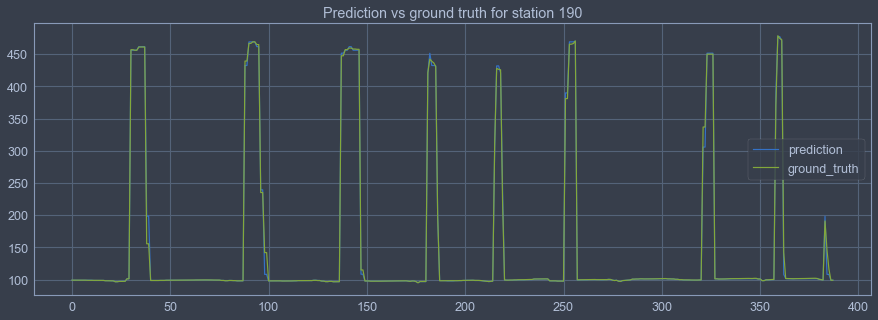

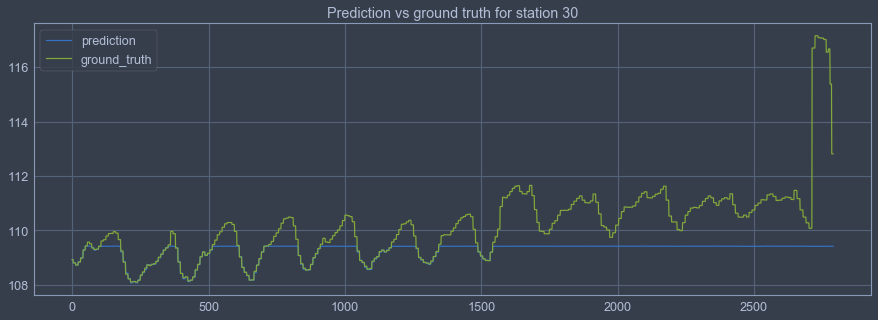

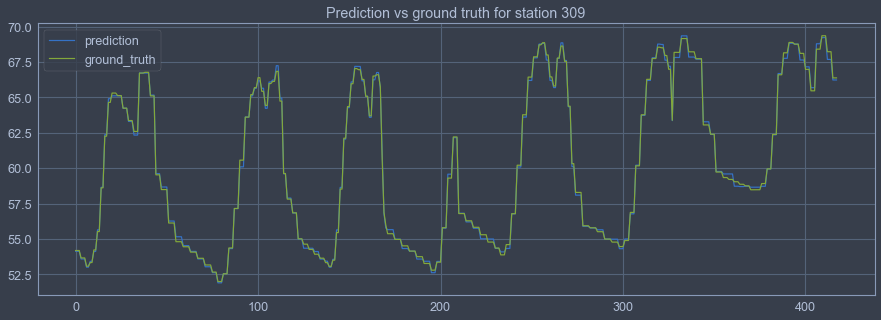

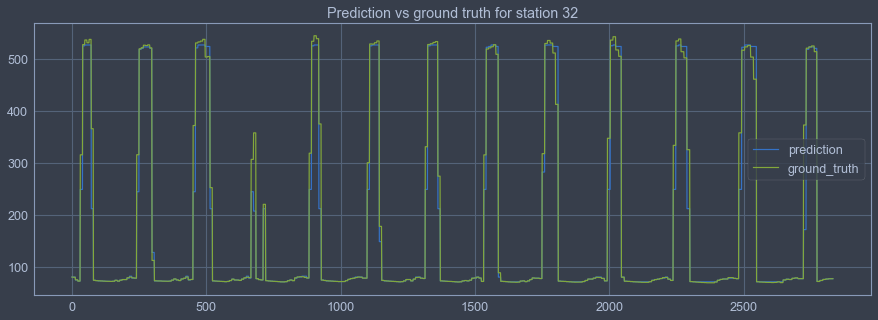

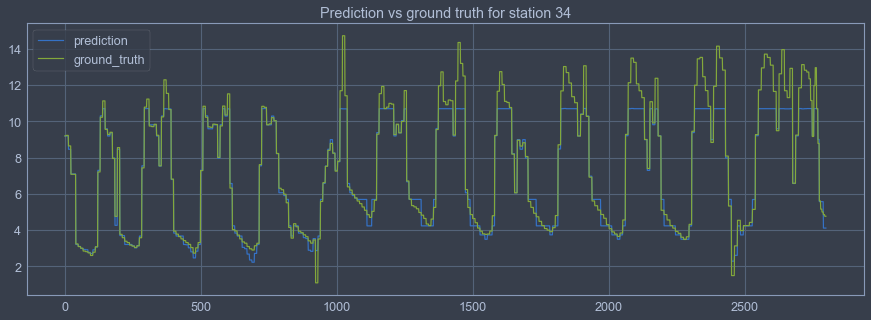

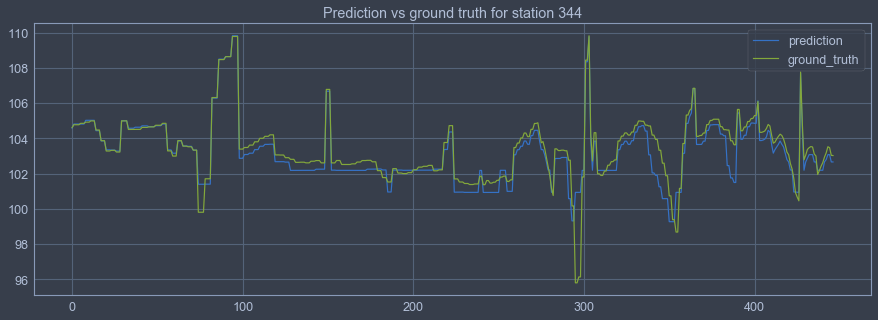

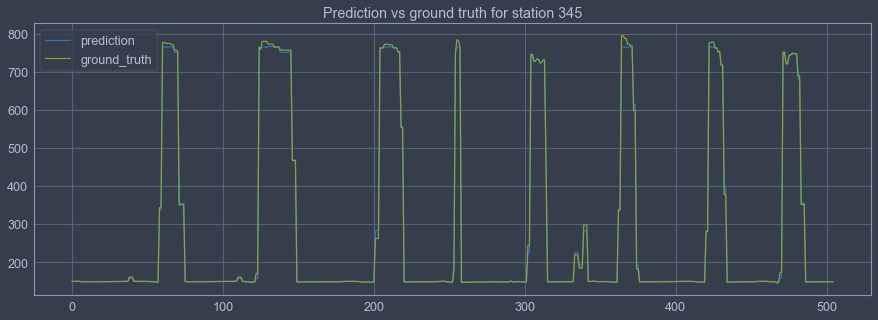

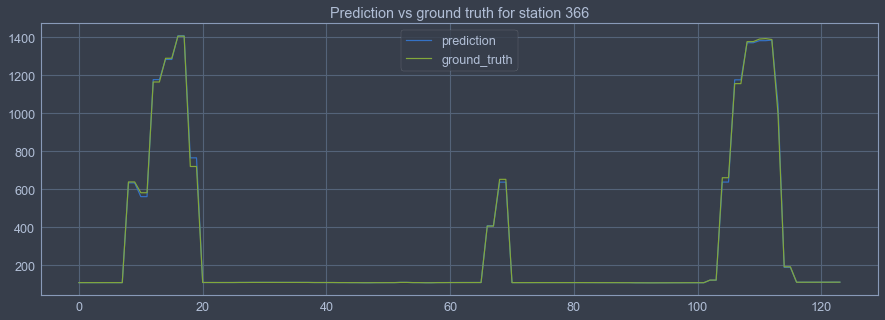

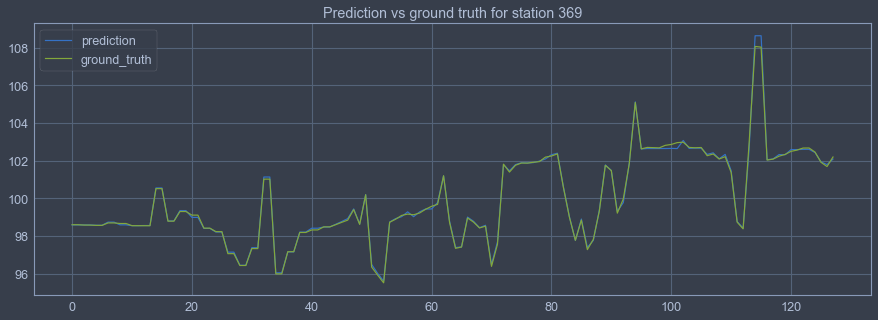

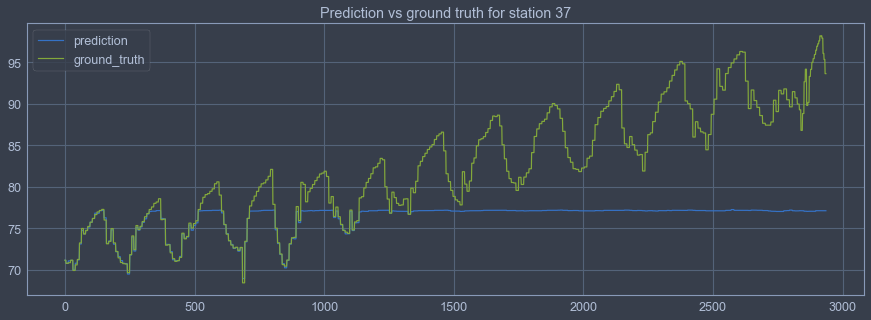

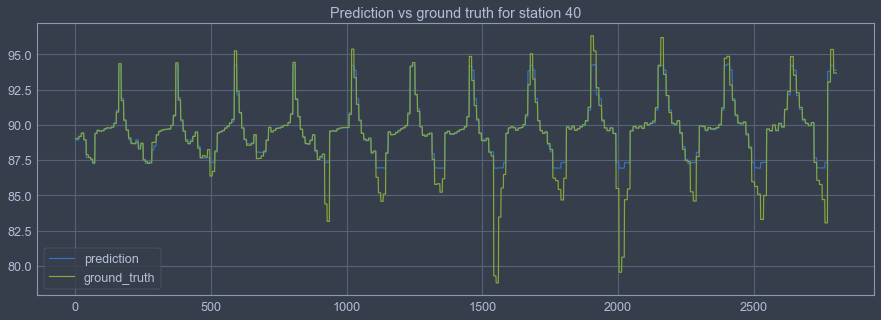

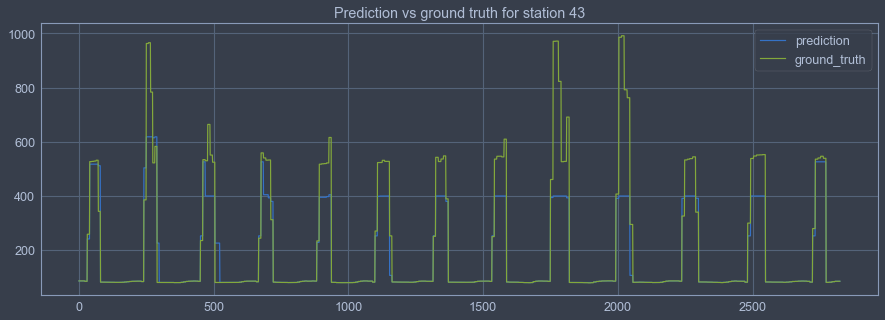

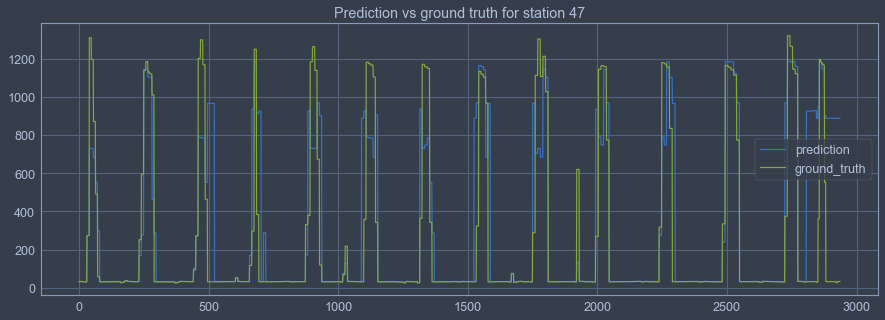

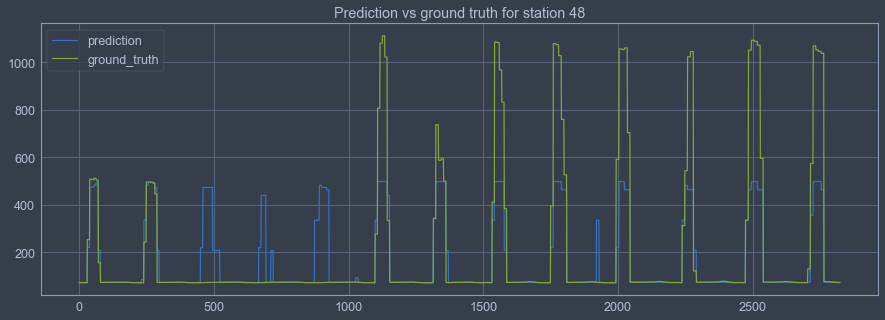

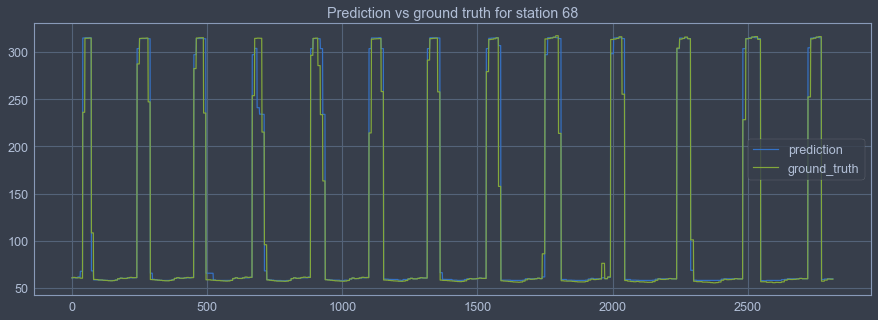

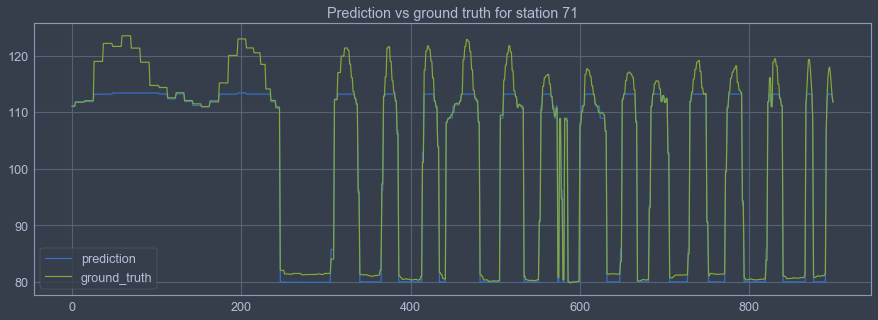

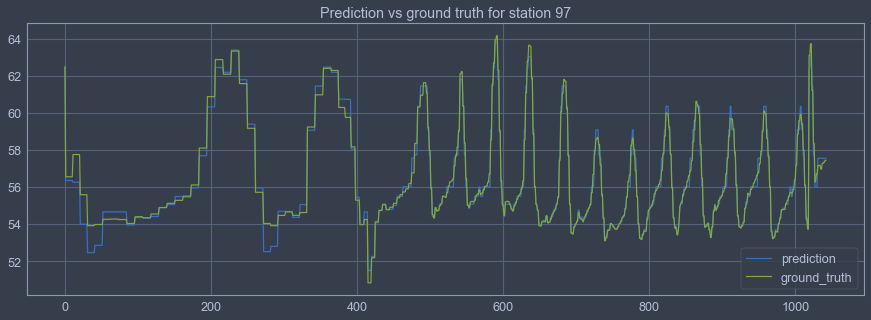

In [171]:
for station in stations:
    plt.figure(figsize=(15, 5))
    plt.plot(predictions.loc[station, 'prediction'].values, label='prediction')
    plt.plot(predictions.loc[station, 'ground_truth'].values, label='ground_truth')
        
    plt.title('Prediction vs ground truth for station {}'.format(station))
    plt.legend()
    plt.show()